In [1]:
import os
import time
import yaml

from PIL import Image

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F

from kornia.losses import ssim_loss

from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm

from Models.BrownianBridgeModel.UNet import UNetModel
# from generative.networks.nets.diffusion_model_unet import DiffusionModelUNet

from generative.networks.schedulers.ddpm import DDPMScheduler

from utils import namespace2dict, dict2namespace, create_gif

In [2]:
def load_config(config_path):
    with open(config_path, 'r') as f:
        dict_config = yaml.load(f, Loader=yaml.FullLoader)
    n_config = dict2namespace(dict_config)
    
    if n_config.model.test_unet_exclusive:
        n_config.model.use_condition = False
        
    if n_config.model.use_condition:
        n_config.model.DDPM.UNetParams.in_channels = 2
    else:
        n_config.model.DDPM.UNetParams.in_channels = 1
    
    return n_config, namespace2dict(n_config) 

def load_unet_model(run, epoch = 0):
    results_path = "/home/s1736191/myjupyter/DiffusionMAR/Results"
    run = str(run)
    results_path = os.path.join(results_path, run)

    config_file = "config.yaml"
    config_path = os.path.join(results_path, config_file)

    n_config, _ = load_config(config_path)

    unet_config = n_config.model.DDPM.UNetParams
    #epochs = n_config.trainingparams.epochs
    test_unet_exclusive = n_config.model.test_unet_exclusive
    use_condition = n_config.model.use_condition
    loss_type = n_config.model.DDPM.params.loss_type
    
    DEVICE = torch.device('cpu')
    
    checkpoints_folder = "Checkpoints"
    checkpoints_path = os.path.join(results_path, checkpoints_folder)
    for epoch_file in os.listdir(checkpoints_path):
        if '_' + str(epoch-1) + '.' in epoch_file:
            last_epoch_file = epoch_file
            break
    
    # Load unet model
    model = UNetModel(**vars(unet_config)).to(device=DEVICE)
    
    model.load_state_dict(torch.load(os.path.join(checkpoints_path, last_epoch_file), map_location=DEVICE)['state_dict'])
    model.eval()
    return model

def get_mean_per_pixel(img_array):    
    mean_per_pixel = np.zeros_like(img_array[0])
    for img in img_array:
        mean_per_pixel += img
    return mean_per_pixel/len(img_array)

def get_var_per_pixel(img_array, mean_per_pixel):
    var_per_pixel = np.zeros_like(img_array[0])
    for img in img_array:
        img = img - mean_per_pixel
        img = img ** (2)
        var_per_pixel += img
    return var_per_pixel/len(img_array)

def get_inp_tar(path):
    return np.load(os.path.join(path, 'input.npy')), np.load(os.path.join(path, 'target.npy'))

def get_chains(path):
    chains_diffusion = []
    chains_onestep = []
    for item in os.listdir(path):
        if 'diffusion' in item:
            chains_diffusion.append(np.load(os.path.join(path, item)))
        elif 'onestep' in item:
            chains_onestep.append(np.load(os.path.join(path, item)))
    return chains_diffusion, chains_onestep

def get_predictions(path):
    predictions = []
    for item in os.listdir(path):
        if 'prediction' in item:
            predictions.append(np.load(os.path.join(path, item)))
    return predictions

def get_results(path):
    chains_diffusion = []
    chains_onestep = []
    predictions = []
    for item in os.listdir(path):
        if 'diffusion' in item:
            chains_diffusion.append(np.load(os.path.join(path, item)))
        elif 'onestep' in item:
            chains_onestep.append(np.load(os.path.join(path, item)))
        elif 'prediction' in item:
            predictions.append(np.load(os.path.join(path, item)))
    return chains_diffusion, chains_onestep, predictions

def split_chain(chain):
    array = []
    shape = np.shape(chain)
    img_size = shape[2]
    steps = int(shape[3] / img_size)
    for img_i in range(steps):
        array.append(chain[0, 0, :, 256*(img_i): 256*(img_i+1)])
    return array

def toHU(sample):
    return sample * 2000 + 1000

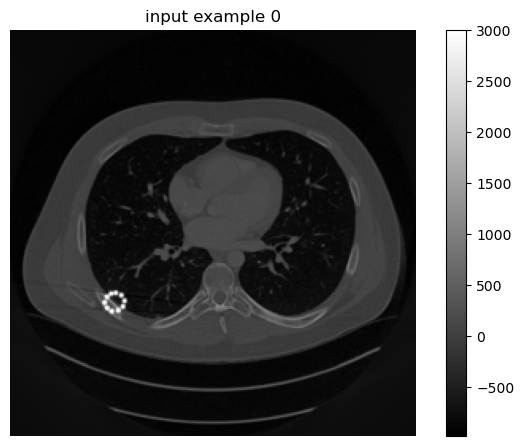

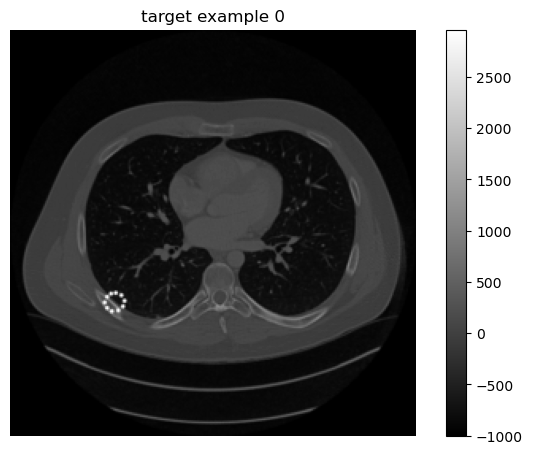

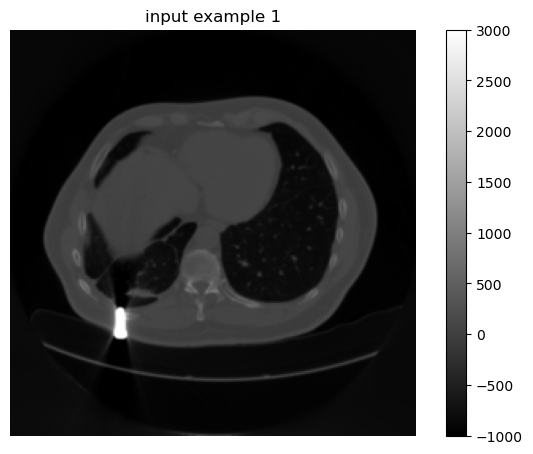

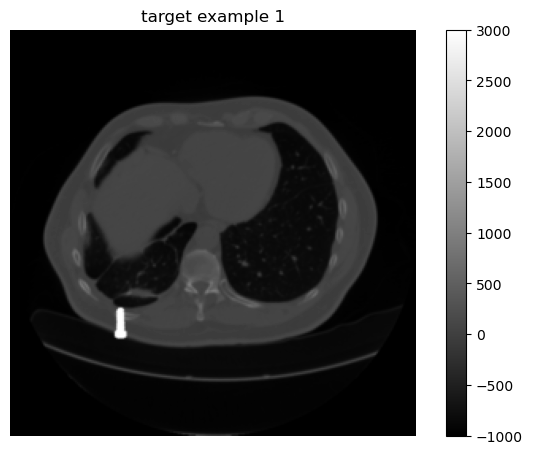

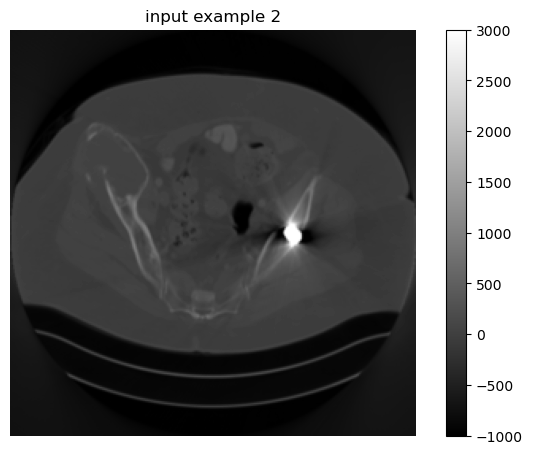

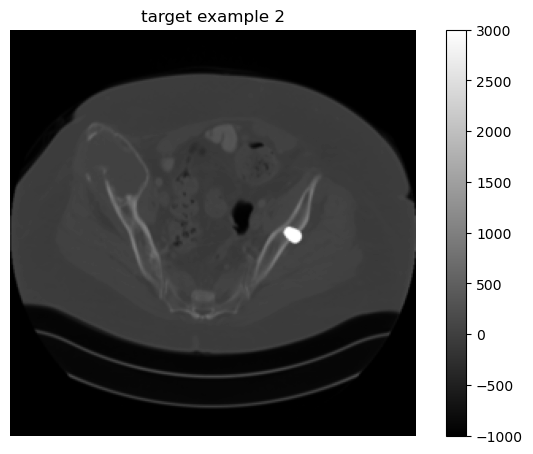

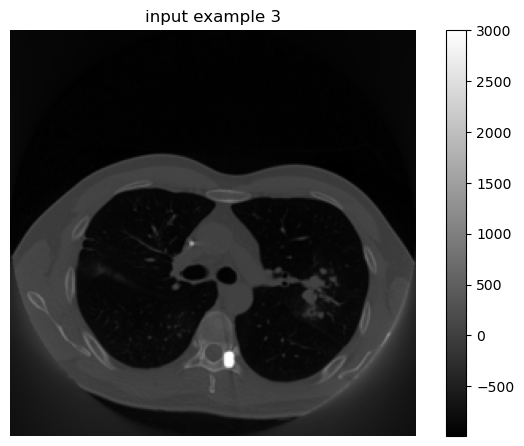

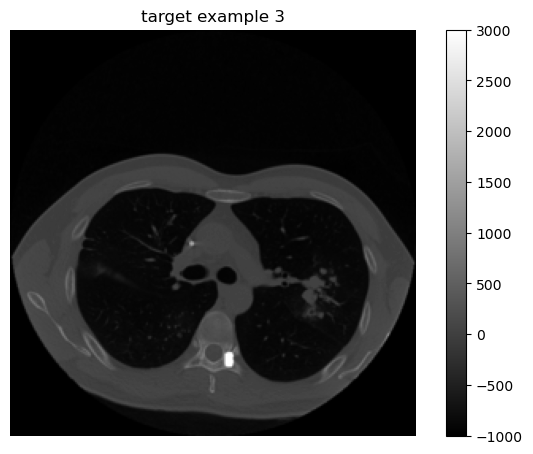

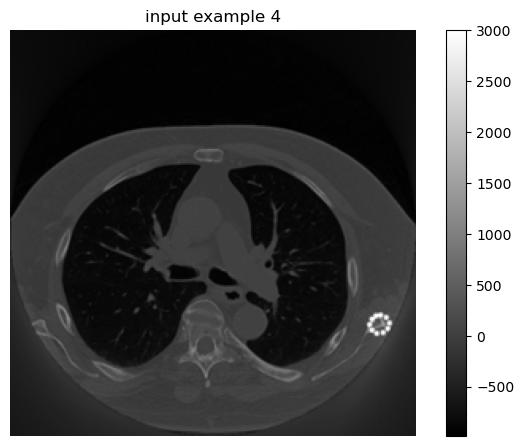

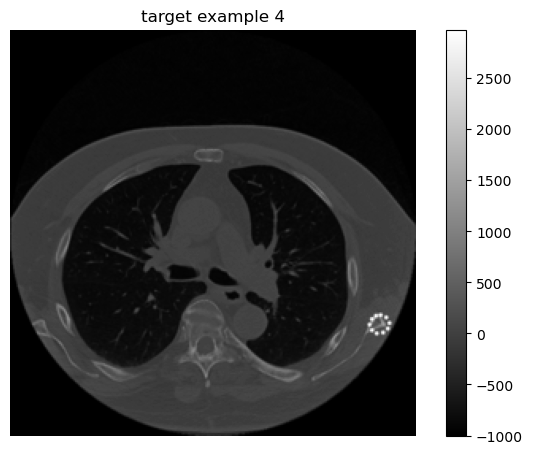

In [3]:
path = '/home/s1736191/myjupyter/DiffusionMAR/eval_images/'
model = 'DDPM_lin-example_'

n_examples = 5

inps_tars = []

full_paths = []
for example_i in range(n_examples):
    full_paths.append(os.path.join(path, model + str(example_i)))
    
    inp, tar = get_inp_tar(full_paths[-1])
    inps_tars.append([inp, tar])
    
    plt.figure()
    plt.title('input example ' + str(example_i))
    plt.imshow(toHU(inp), cmap='gray')
    plt.colorbar()
    plt.tight_layout()
    plt.axis("off")
    plt.show()
    plt.figure()
    plt.title('target example ' + str(example_i))
    plt.imshow(toHU(tar), cmap='gray')
    plt.colorbar()
    plt.tight_layout()
    plt.axis("off")
    plt.show()  

prediction 0
ssim loss: 0.0015236390754580498


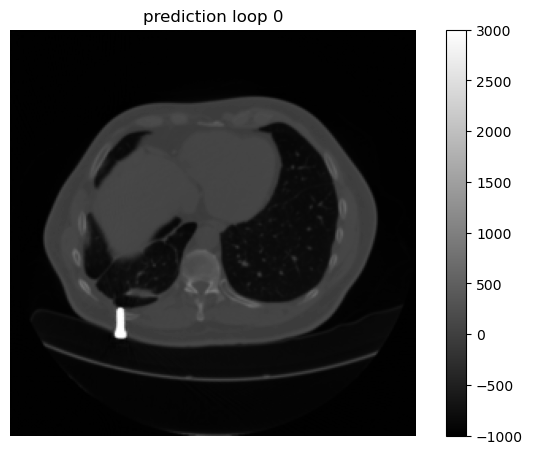

prediction 1
ssim loss: 0.0014751226408407092


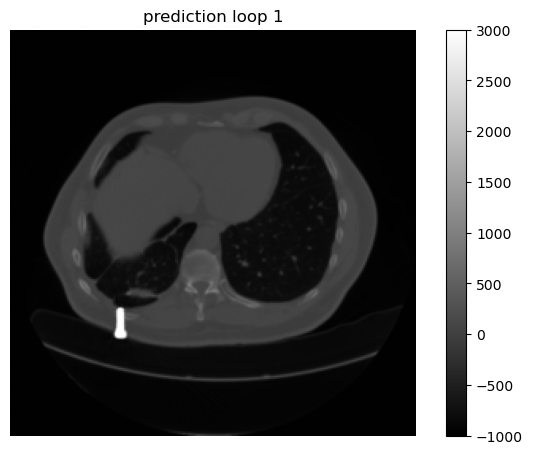

prediction 2
ssim loss: 0.0015387104358524084


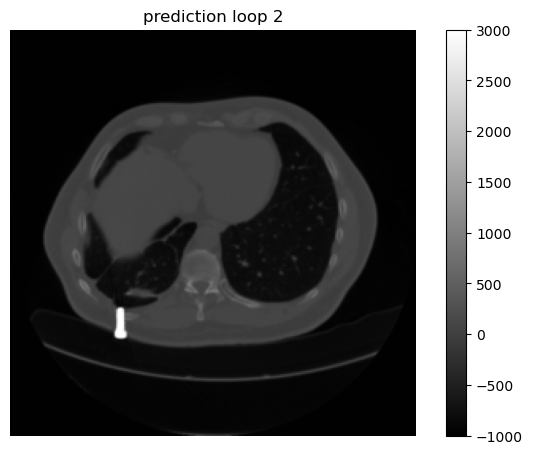

prediction 3
ssim loss: 0.0014888133155182004


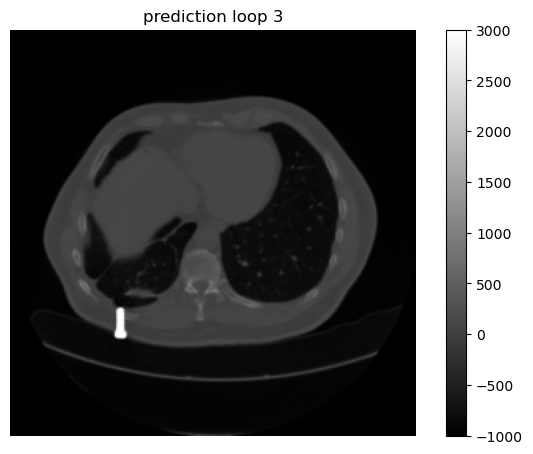

prediction 4
ssim loss: 0.0014858775539323688


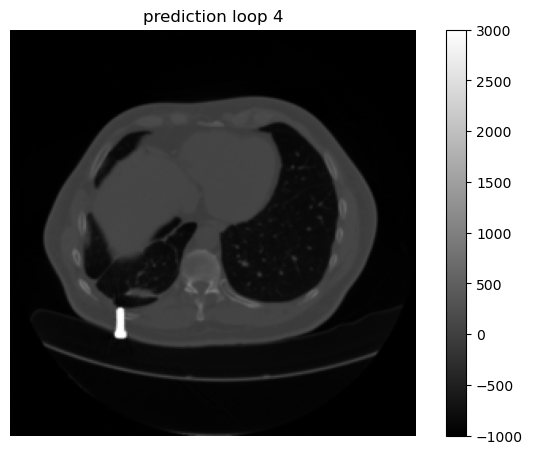

prediction 5
ssim loss: 0.001448758994229138


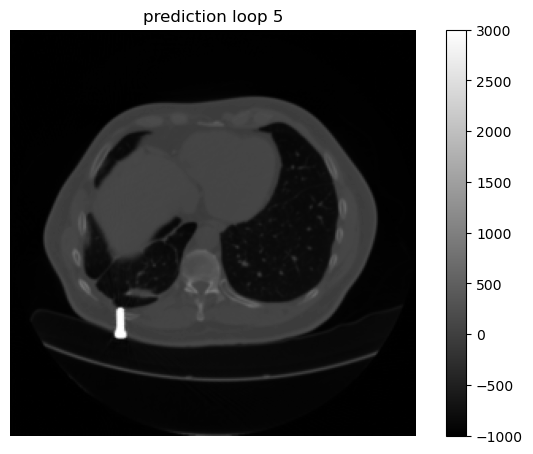

prediction 6
ssim loss: 0.0016183331608772278


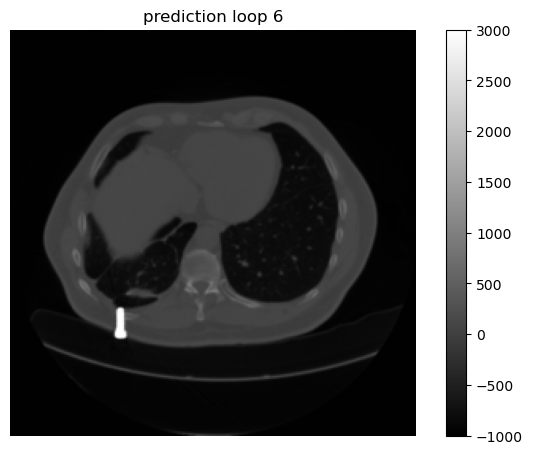

prediction 7
ssim loss: 0.0015207899268716574


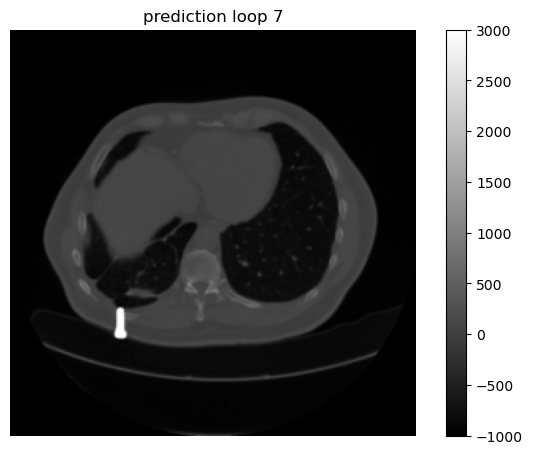

prediction 8
ssim loss: 0.0016049968544393778


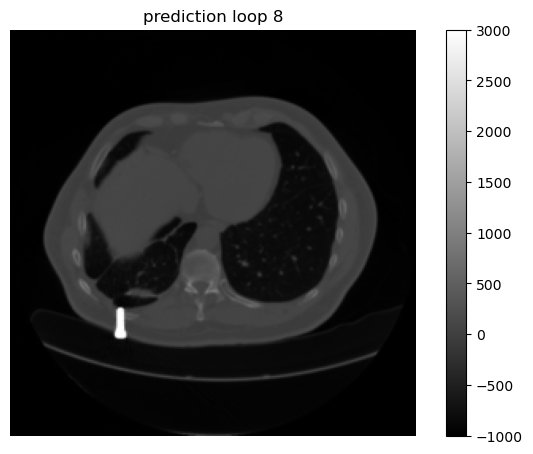

prediction 9
ssim loss: 0.0015630570705980062


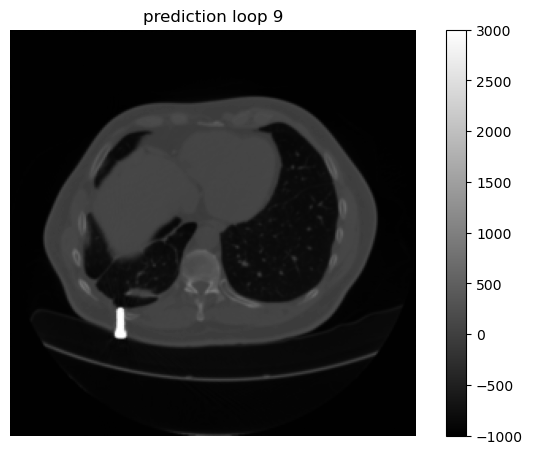

In [24]:
predictions = get_predictions(full_paths[1])
inp, tar = get_inp_tar(full_paths[1])

for i, prediction in enumerate(predictions):
    print('prediction ' + str(i))
    ssimloss = ssim_loss(torch.Tensor(prediction).unsqueeze(dim=0).unsqueeze(dim=0), torch.Tensor(tar).unsqueeze(dim=0).unsqueeze(dim=0), 11)
    print('ssim loss:', ssimloss.item())
    
    plt.figure()
    plt.title('prediction loop ' + str(i))
    plt.imshow(toHU(prediction), cmap='gray')
    plt.colorbar()
    plt.tight_layout()
    plt.axis("off")
    plt.show()

ssim loss: 0.0013258676044642925


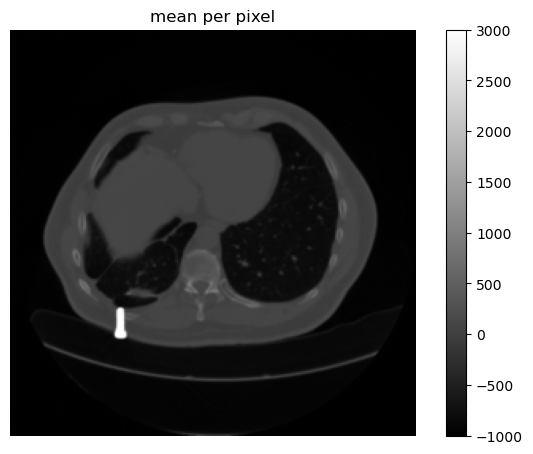

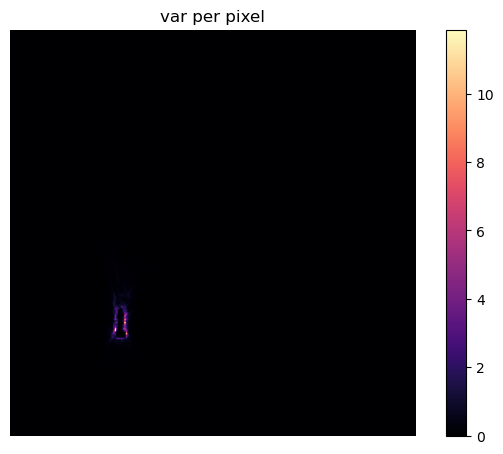

In [25]:
mean_per_pixel = get_mean_per_pixel(predictions)
var_per_pixel = get_var_per_pixel(predictions, mean_per_pixel)

ssimloss = ssim_loss(torch.Tensor(mean_per_pixel).unsqueeze(dim=0).unsqueeze(dim=0), torch.Tensor(tar).unsqueeze(dim=0).unsqueeze(dim=0), 11)
print('ssim loss:', ssimloss.item())

plt.figure()
plt.title('mean per pixel')
plt.imshow(toHU(mean_per_pixel), cmap='gray')
plt.colorbar()
plt.tight_layout()
plt.axis("off")
plt.show()

plt.figure()
plt.title('var per pixel')
plt.imshow(2000 * var_per_pixel, cmap='magma')
plt.colorbar()
plt.tight_layout()
plt.axis("off")
plt.show()

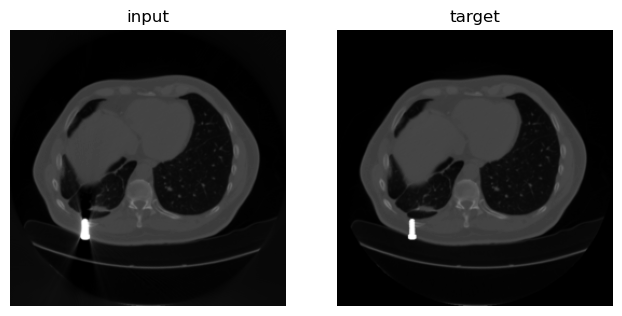

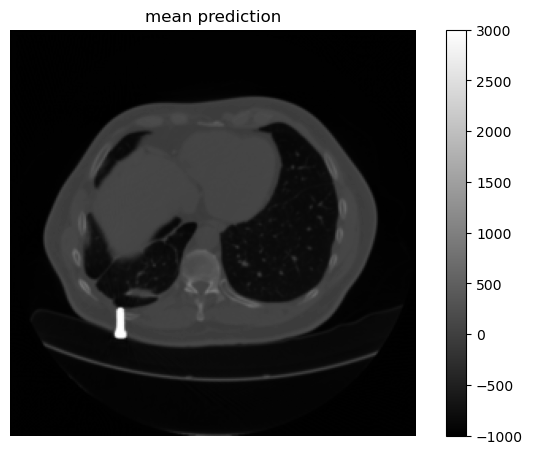

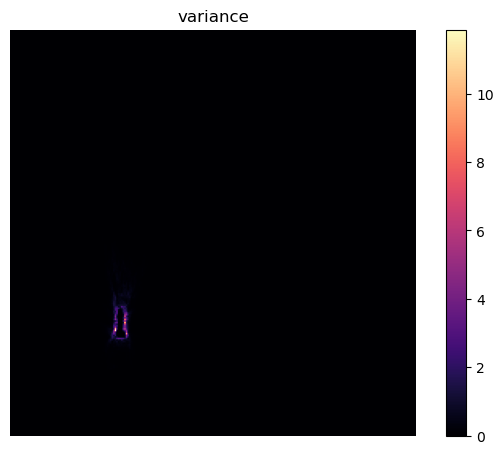

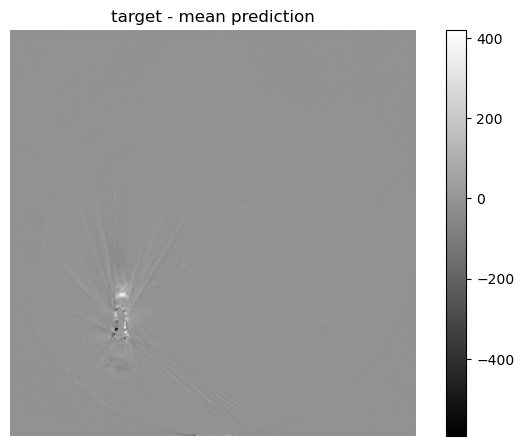

In [26]:
plt.figure()
plt.subplot(121)
plt.title('input')
plt.imshow(toHU(inp), cmap='gray')
plt.tight_layout()
plt.axis("off")
plt.subplot(122)
plt.title('target')
plt.imshow(toHU(tar), cmap='gray')
plt.tight_layout()
plt.axis("off")
plt.show()

plt.figure()
plt.title('mean prediction')
plt.imshow(toHU(mean_per_pixel), cmap='gray')
plt.colorbar()
plt.tight_layout()
plt.axis("off")
plt.show()

plt.figure()
plt.title('variance')
plt.imshow(2000 * (var_per_pixel), cmap='magma')
plt.colorbar()
plt.tight_layout()
plt.axis("off")
plt.show()

plt.figure()
plt.title('target - mean prediction')
plt.imshow(2000 * (tar - mean_per_pixel), cmap='gray')
plt.colorbar()
plt.tight_layout()
plt.axis("off")
plt.show()

(1000, 256, 256)


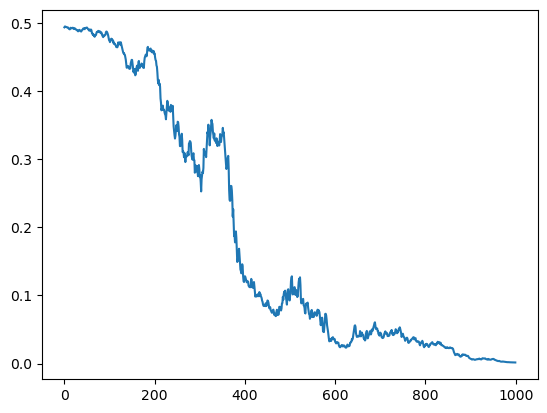

In [27]:
n = 1
chains_diff, chains_ones = get_chains(full_paths[n])

chains_diff_split = []
chains_ones_split = []
for i, chain in enumerate(chains_diff):
    #print(np.array(chain).shape)
    chains_diff_split.append(split_chain(chain))
    chains_ones_split.append(split_chain(chains_ones[i]))
    
print(np.array(chains_ones_split[0]).shape)
    
for chain in chains_ones_split:
    ssim_losses = []
    for img in chain:
        ssimloss = ssim_loss(torch.Tensor(img).unsqueeze(dim=0).unsqueeze(dim=0), torch.Tensor(tar).unsqueeze(dim=0).unsqueeze(dim=0), 11)
        ssim_losses.append(ssimloss.item())
    plt.figure()
    plt.plot(ssim_losses)
    plt.show()
    break

In [28]:
print(ssim_losses[-1])

0.0015236390754580498


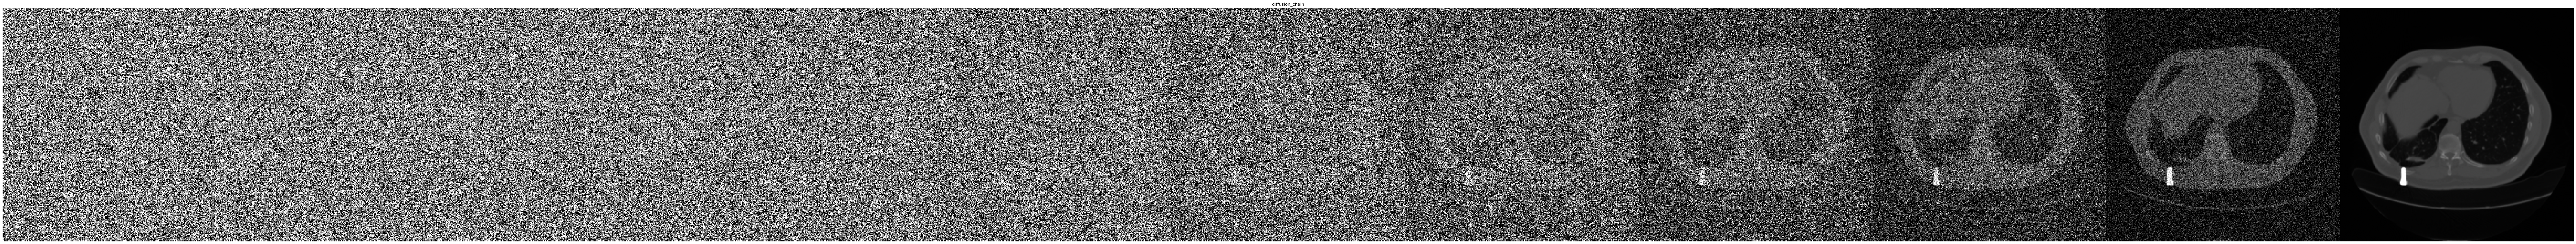

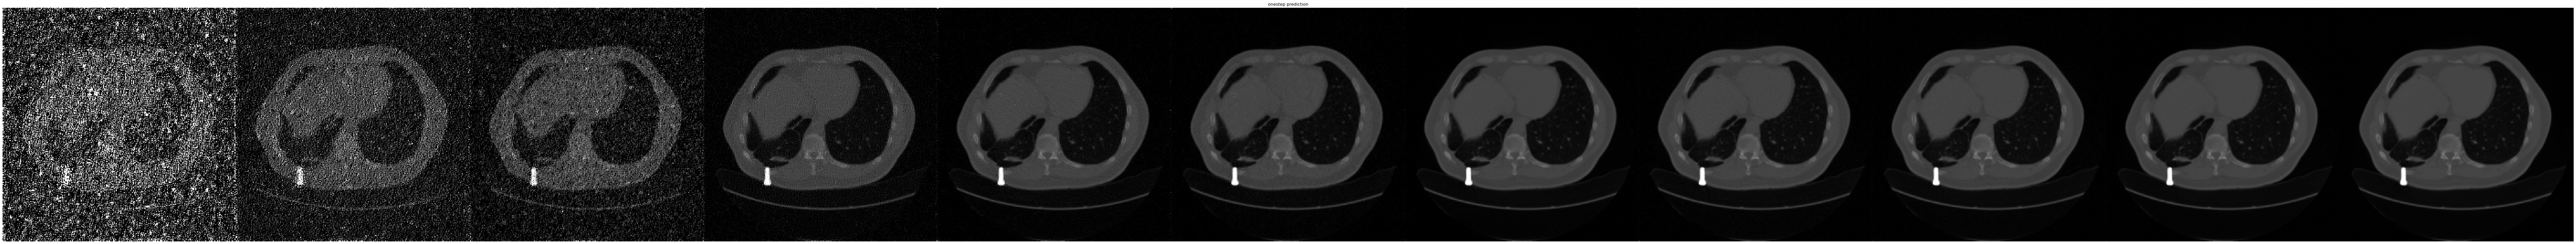

In [29]:
dc = chains_diff_split[0]
oc = chains_ones_split[0]

n_img = 10 #+ last

outd = []
outo = []
for i in range(len(dc)):
    if i % (1000/n_img) == 0 or i == 999:
        outd.append(dc[i])
        outo.append(oc[i])
        
plt.figure(figsize=(n_img*10, 10))
plt.title('diffusion_chain')
plt.imshow(toHU(np.concatenate(outd, axis=1)), vmin=-1000, vmax=3000, cmap='gray')
plt.tight_layout()
plt.axis("off")
plt.show()

plt.figure(figsize=(n_img*10, 10))
plt.title('onestep prediction')
plt.imshow(toHU(np.concatenate(outo, axis=1)), vmin=-1000, vmax=3000, cmap='gray')
plt.tight_layout()
plt.axis("off")
plt.show()

In [30]:
UNET = load_unet_model('UNET', 12)

unet_preds = []
for inp, tar in inps_tars:
    unet_inp = torch.Tensor(inp)
    unet_inp = unet_inp.unsqueeze(0).unsqueeze(0)
    unet_preds.append(UNET(unet_inp, timesteps=torch.Tensor((1,))))

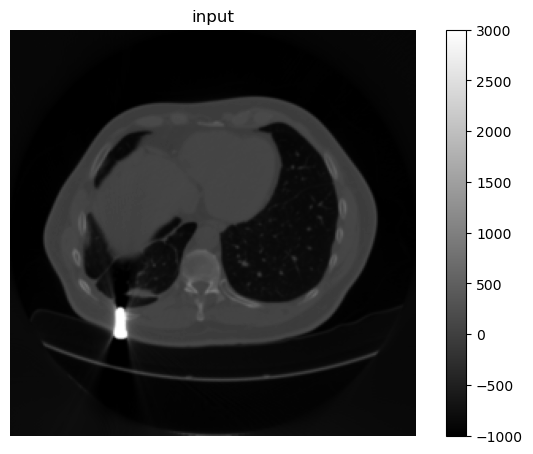

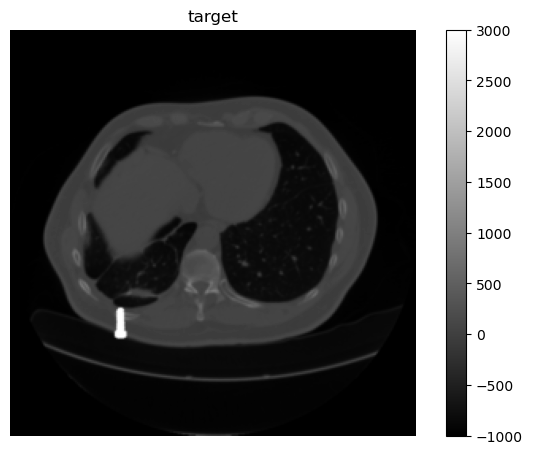

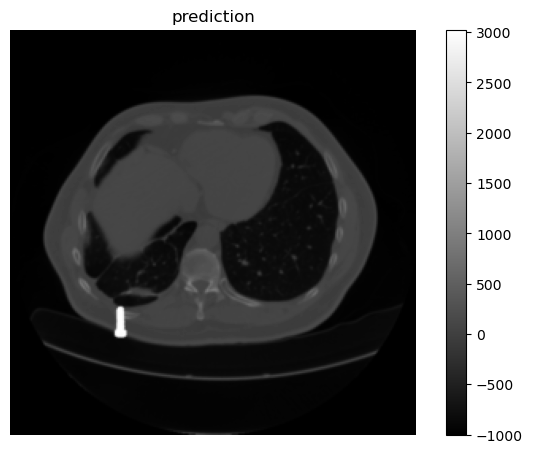

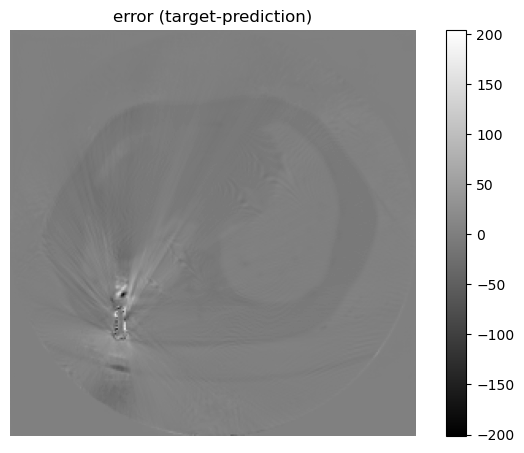

In [31]:
x_i = 1

prediction = unet_preds[x_i].squeeze().detach().numpy() 

plt.figure()
plt.title('input')
plt.imshow(toHU(inps_tars[x_i][0]), cmap='gray')
plt.colorbar()
plt.tight_layout()
plt.axis("off")
plt.show()
plt.figure()
plt.title('target')
plt.imshow(toHU(inps_tars[x_i][1]), cmap='gray')
plt.colorbar()
plt.tight_layout()
plt.axis("off")
plt.show()
plt.figure()
plt.title('prediction')
plt.imshow(toHU(prediction), cmap='gray')
plt.colorbar()
plt.tight_layout()
plt.axis("off")
plt.show()
plt.figure()
plt.title('error (target-prediction)')
plt.imshow(2000*(inps_tars[x_i][1] - prediction), cmap='gray')
plt.colorbar()
plt.tight_layout()
plt.axis("off")
plt.show()

In [32]:
loss = ssim_loss(unet_preds[x_i], torch.Tensor(inps_tars[x_i][1]).unsqueeze(dim=0).unsqueeze(dim=0), 11).item()
print(loss)

0.000446949852630496


/tmp/ipykernel_2915723/3913225878.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(131)


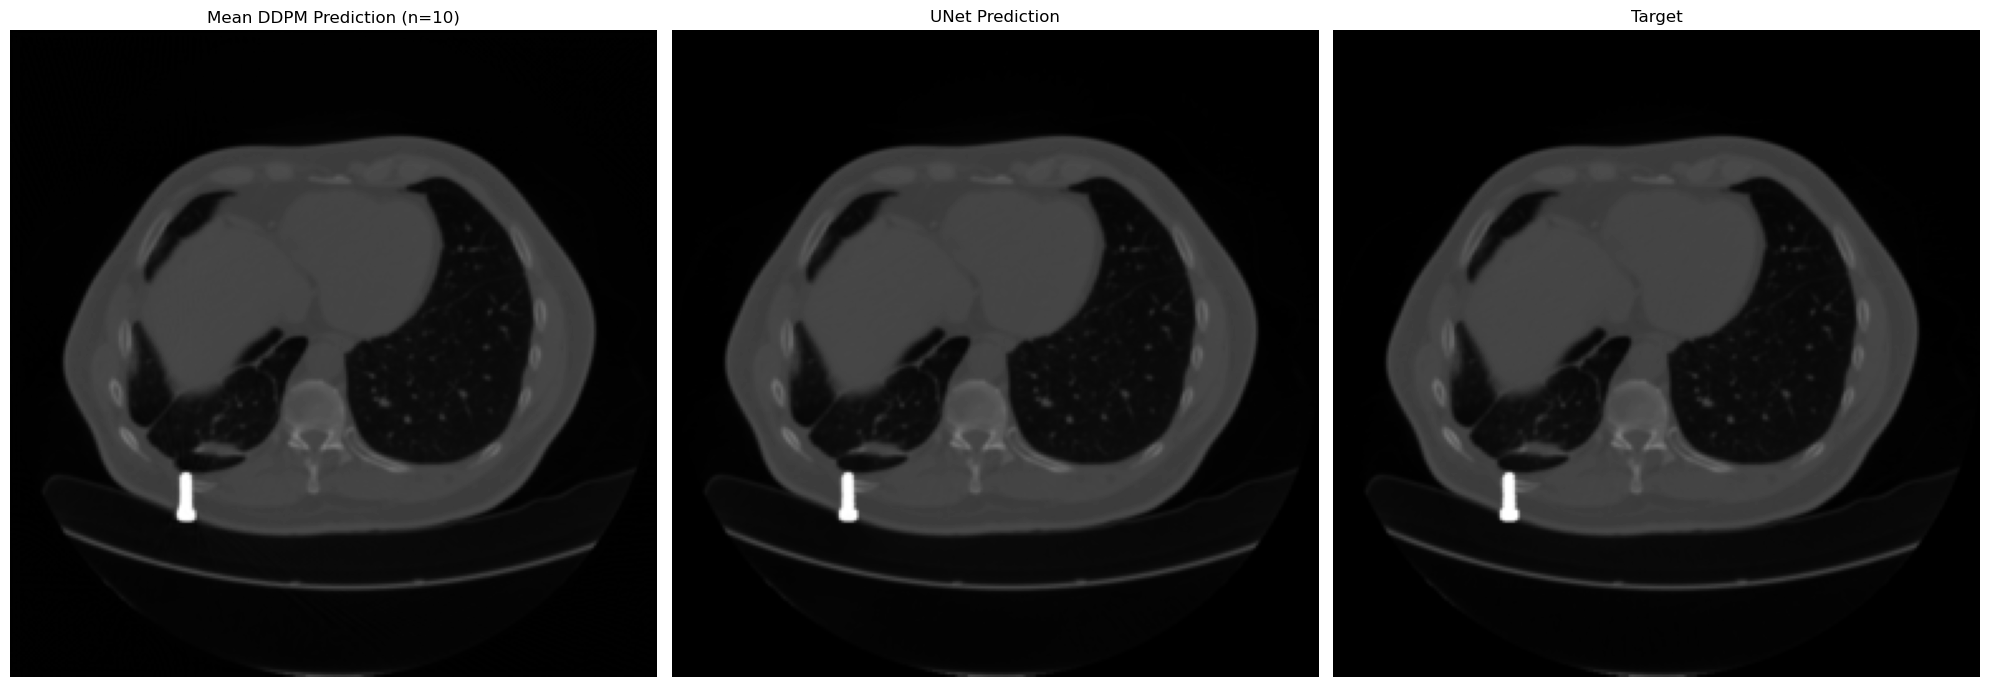

In [33]:
plt.figure(figsize=(20, 60))
plt.title('prediction diff (ddpm, unet)')

plt.subplot(131)
plt.title('Mean DDPM Prediction (n=10)')
plt.imshow(toHU(mean_per_pixel), cmap='gray')
plt.axis("off")
plt.tight_layout()
plt.subplot(132)
plt.title('UNet Prediction')
plt.imshow(toHU(prediction), cmap='gray')
plt.axis("off")
plt.tight_layout()
plt.subplot(133)
plt.title('Target')
plt.imshow(toHU(inps_tars[x_i][1]), cmap='gray')
plt.axis("off")
plt.tight_layout()
plt.show()